In [1]:
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import time
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [2]:
from functions import *

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sil import *

In [3]:
base_table = '_erc3'

In [4]:
def get_common_functions(token_type='ERC20', n=8):
    
    sql = '''
    with a as (SELECT *
    FROM `contract-explorer-233919.ethparis.functions{}`
    ),

    b as (select * from `contract-explorer-233919.ethparis.erclist`
      where token_type='{}' ),

    c as (
    select a.*
    from a
    inner join b
    ON LOWER(a.addr) = b.address)


    select 
    signature, count(*) as total_functions
    from c
    GROUP BY signature
    '''.format(base_table, token_type)

    df1 = client.query(sql, location='europe-west2').to_dataframe()

    df1 = df1.sort_values(by='total_functions', ascending=False)

    return tuple(df1.signature.values[1:n+1])

In [5]:
common_functions = get_common_functions(token_type='ERC20', n=8)

## Get list of common functions

In [6]:
#mandatory ERC20 functions
common_functions = ('balanceOf(address)',
 'transfer(address,uint256)',
 'totalSupply()',
 'allowance(address,address)',
 'transferFrom(address,address,uint256)',
  'approve(address,uint256)')

In [7]:
# common_functions = ('transfer(address,uint256)', 'transferFrom(address,address,uint256)',)

## Get list of labels from etherscan

In [8]:
sql = '''

  SELECT *  FROM`contract-explorer-233919.ethparis.etherscan_labels`
 

'''


labels = client.query(sql, location='europe-west2').to_dataframe()

In [9]:
label_addr = tuple(labels.address.unique())

In [ ]:
## Get all

In [10]:
sql = '''
 with a as (SELECT *
    FROM `contract-explorer-233919.ethparis.functions{}`
    ),

    b as (select * from `contract-explorer-233919.ethparis.erclist`
      where token_type='{}' ),

    c as (
    select a.*
    from a
    inner join b
    ON LOWER(a.addr) = b.address)

  SELECT distinct(addr)  FROM c
  --WHERE LOWER(addr) in {}
  --LIMIT 5000
'''.format(base_table,'ERC20', label_addr)

contract_addrs = client.query(sql, location='europe-west2').to_dataframe()
contract_addrs = tuple(contract_addrs['addr'].values)

In [11]:
#template for selecting only given function from address in our list

sql='''
 with aa as (SELECT *
    FROM `contract-explorer-233919.ethparis.functions{}`
    ),

    bb as (select * from `contract-explorer-233919.ethparis.erclist`
      where token_type='ERC20' ),

    cc as (
    select aa.*
    from aa
    inner join bb
    ON LOWER(aa.addr) = bb.address),
    
    
    address_list as(
  SELECT distinct(addr)  FROM cc
  --LIMIT 5000
  ),
  
  function_subset as(
select * from cc where signature IN {}),

totals as (
select fs.* from function_subset fs
inner join address_list al
on fs.addr = al.addr),

addresses as(
select addr, count(signature) as num_funcs, count(distinct signature) as num_funcs_distinct
from totals
group by addr),

addresses_filtered as(
select * from addresses
where True
and num_funcs = num_funcs_distinct
and num_funcs = {})


select t.* from totals t
inner join addresses_filtered af
on t.addr = af.addr
'''

In [12]:


sql1 = sql.format(base_table,str(common_functions), len(common_functions))
df_all = client.query(sql1, location='europe-west2').to_dataframe()

    
    
    

In [13]:
dfs = {}
for cf in common_functions:
    mask = (df_all.signature==cf)
    df = df_all[mask]
    
    dfs[cf] = {}
    dfs[cf]['df'] = df


## Create features / vocabulary for every function being analyzed

building pipeline for balanceOf(address)
starting tsne for balanceOf(address)
t-SNE done! Time elapsed: 22.6490740776062 seconds


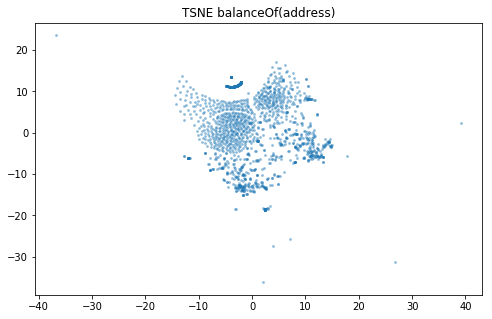

building pipeline for transfer(address,uint256)
starting tsne for transfer(address,uint256)
t-SNE done! Time elapsed: 17.23696994781494 seconds


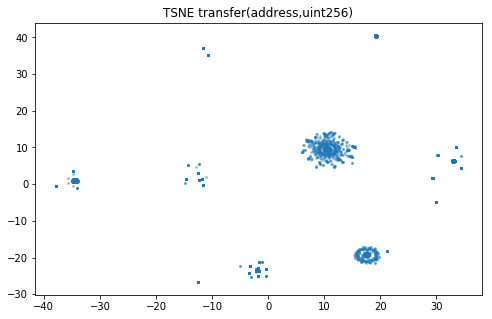

building pipeline for totalSupply()
starting tsne for totalSupply()
t-SNE done! Time elapsed: 34.63170003890991 seconds


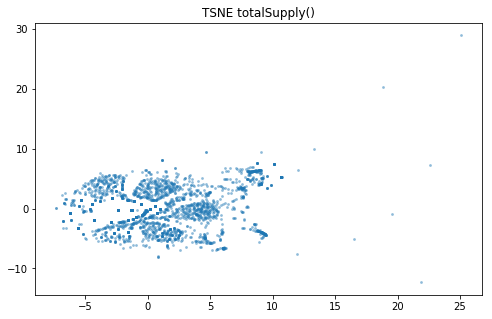

building pipeline for allowance(address,address)
starting tsne for allowance(address,address)
t-SNE done! Time elapsed: 25.681217670440674 seconds


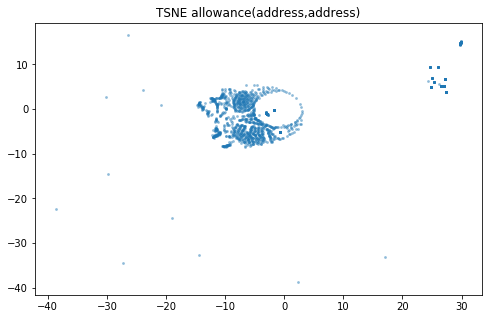

building pipeline for transferFrom(address,address,uint256)
starting tsne for transferFrom(address,address,uint256)
t-SNE done! Time elapsed: 21.152017831802368 seconds


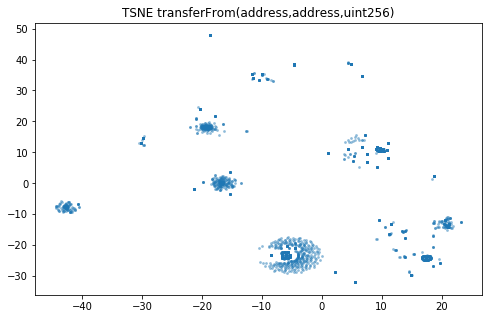

building pipeline for approve(address,uint256)
starting tsne for approve(address,uint256)
t-SNE done! Time elapsed: 27.470749855041504 seconds


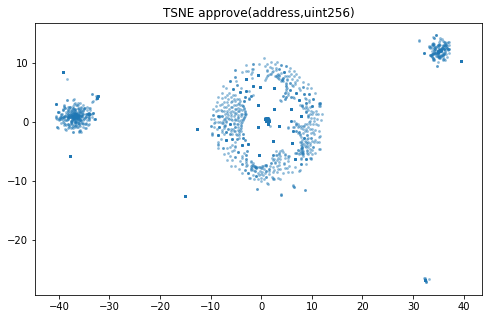

In [14]:
#build pipeline for each function, save pipe and results into dict


for d,v in dfs.items():
    #add trees
    v['target'] =  v['df']['hash']
    v['trees'] = v['df']['tree']
    #build and fit pipeline
    print('building pipeline for {}'.format(d))
    X = Preprocess().fit_transform(v['trees'])
    vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
    toArray = ToArray()
    shp = toArray.fit_transform(vectorizer.fit_transform(X)).shape
    n_comp = min(shp)
    
    pca = PCA(n_components=n_comp)
    pipe = Pipeline([('vectorizer', vectorizer ),
                ('toArray', toArray),
                 ('pca', pca)])
    
    result = pipe.fit_transform(X)
  
    
    #perform tsne - can skip
    print('starting tsne for {}'.format(d))
    time_start = time.time()
    tsne = TSNE(n_components=2, perplexity=60, n_iter=1000,verbose=False,learning_rate=100)
    
    tsne_results = tsne.fit_transform(result[:3000])
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
    
    
#     #silhouette scores without plotting
#     range_n_clusters = list(i for i in range(2,5,1))
#     sils = np.array(sil_scores_only(result, range_n_clusters))
    
#     #automatically determine number of clusters
#     n_clusters = range_n_clusters[sils.argmax()]
#     print('optimal clusters is {}'.format(n_clusters))
    
    #create cluster object
#    cl = KMeans(n_clusters).fit(result)
    
    #save to dictionary
    v['pipe'] = pipe
    v['result'] = result
#     v['tsne'] = tsne_results
#    v['cl'] = cl

    #plot tsne - can skip because only exploratory
    fig = plt.figure(figsize=(8,5))
#     colors = cm.nipy_spectral(cl.labels_.astype(float) / 10)
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], marker='.', s=30, lw=0, alpha=.5,
                edgecolor='k')


    plt.title("TSNE {}".format(d))
    plt.show()








In [15]:
result_start = df_all.groupby('addr')[['hash']].count().reset_index()

In [17]:

#group all results together
result_list = [result_start]
for func, v in dfs.items():
    result_list.append(pd.DataFrame(v['result']))



In [18]:
contract = reduce(lambda x, y: pd.concat([x, y], axis=1, sort=False ), result_list)
contract.drop(columns='hash', inplace=True)

contract.set_index(keys='addr', inplace=True)

In [19]:
contract.shape

(57354, 5703)

In [20]:
# #add features for additional columns
# remaining_funcs = get_common_functions(token_type='ERC20', n=50)[7:50]

In [21]:
# sql='''
# with aa as (SELECT *
#     FROM `contract-explorer-233919.ethparis.functions{}`
#     ),

#     bb as (select * from `contract-explorer-233919.ethparis.erclist`
#       where token_type='ERC20' ),

#     cc as (
#     select aa.*
#     from aa
#     inner join bb
#     ON LOWER(aa.addr) = bb.address
#     ),
    
#     dd as ( 
#     select * from cc
#     where signature in {}
#     ),
    
#     address_list as(
#   SELECT distinct(addr) FROM cc
#   )
  
  
#   select dd.addr, dd.signature
#   from dd
#   inner join address_list al
#   on dd.addr = al.addr
#   '''.format(base_table, str(remaining_funcs))

# df_other = client.query(sql, location='europe-west2').to_dataframe()

In [22]:
# df_other.set_index('addr', inplace=True)

In [23]:
# dum = pd.get_dummies(df_other)

In [24]:
# dum.reset_index(inplace=True)

In [25]:
# df_other = dum.groupby('addr').sum()

In [26]:
contract.shape

(57354, 5703)

In [27]:
# #merge with contract df
# contract = contract.join(df_other)

In [28]:
contract.fillna(0, inplace=True)

In [29]:
#reduce dimensionality
pca = PCA(n_components=min(contract.shape)).fit(contract.values)

In [37]:
#what is explained variance
cumsums = pca.explained_variance_ratio_.cumsum()
desired_variance_explained = .9
n_comp = np.argmax(cumsums>desired_variance_explained)+1
n_comp

29

In [38]:
#change pca to desired n_comp
pca_sub = PCA(n_components=n_comp).fit_transform(contract.values)

In [39]:
#consider subsetting pca randomly to reduce size of dataset for tsne

In [40]:
n_tsne = 10000

In [41]:
#tsne contracts
time_start = time.time()
tsne = TSNE(n_components=2, perplexity=300, n_iter=1000,verbose=False,learning_rate=200)

tsne_results = tsne.fit_transform(pca_sub[:n_tsne])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 133.30794715881348 seconds


In [44]:
#cluster contract data
nn = list(i for i in range(2,20,1))

#automatically choose n clusters
#silhouette scores without plotting
sils = np.array(sil_scores_only(pca_sub[:n_tsne], nn))

#automatically determine number of clusters
n_clusters = nn[sils.argmax()]
print('optimal clusters is {}'.format(n_clusters))

#create cluster object
cl = KMeans(n_clusters).fit(pca_sub)



For n_clusters = 2 The average silhouette_score is : 0.514577011419832
For n_clusters = 3 The average silhouette_score is : 0.5777332125706848
For n_clusters = 4 The average silhouette_score is : 0.4448763755224202
For n_clusters = 5 The average silhouette_score is : 0.44742717854541486
For n_clusters = 6 The average silhouette_score is : 0.4857424519911615
For n_clusters = 7 The average silhouette_score is : 0.49442830386637443
For n_clusters = 8 The average silhouette_score is : 0.5300568352276956
For n_clusters = 9 The average silhouette_score is : 0.5402254074728294
For n_clusters = 10 The average silhouette_score is : 0.5124919931969792
For n_clusters = 11 The average silhouette_score is : 0.5147913701367725
For n_clusters = 12 The average silhouette_score is : 0.548113214969918
For n_clusters = 13 The average silhouette_score is : 0.5545696979839008
For n_clusters = 14 The average silhouette_score is : 0.5597599564138114
For n_clusters = 15 The average silhouette_score is : 0.556

For n_clusters = 18 The average silhouette_score is : 0.5775577772652727


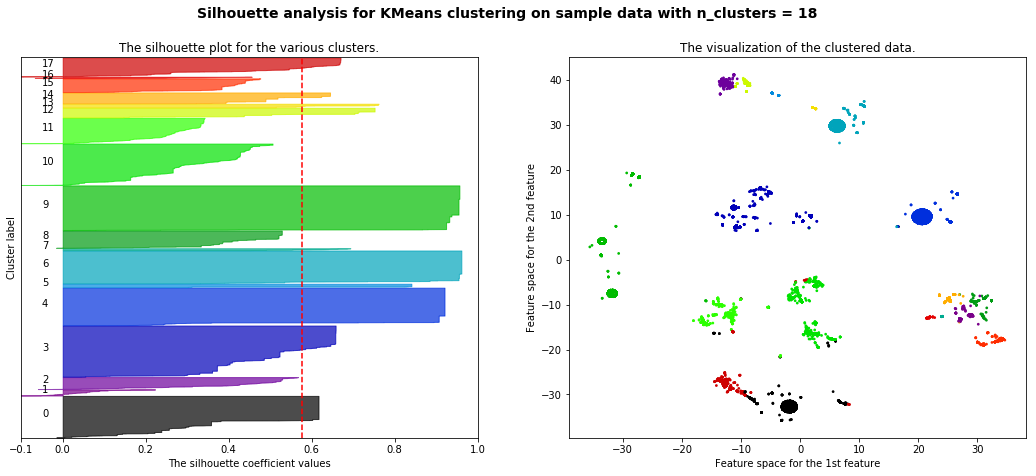

[0.5775577772652727]

In [45]:
silhouette_plotter(pca_sub[:n_tsne], [n_clusters], tsne_results)

In [46]:
contract['cluster'] = cl.labels_

In [47]:
def cluster_sort(pca, cl):
    xx = []
    masks = []
    cluster_numbers = []
    for c in np.unique(cl.labels_):
        mask = c == cl.labels_
        xx.append(pca[mask])
        masks.append(mask)
        cluster_numbers.append(c)
        
    #sort xx by cosine similarity of cluster centers
    
    cc = cl.cluster_centers_
    cos_sim = cosine_similarity(cc)
    idx = cos_sim[0].argsort()
    return [xx[i] for i in idx]


In [48]:
def select_n_clusters(pca):
    #cluster contract data
    nn = [2,3,4,5]

    #automatically choose n clusters
    #silhouette scores without plotting
    sils = np.array(sil_scores_only(pca, nn))

    #automatically determine number of clusters
    n_clusters = nn[sils.argmax()]
    print('optimal clusters is {}'.format(n_clusters))
    return n_clusters

In [49]:
def cluster_sort_recursive(pca):
    if len(pca)<lenpca/20:
        all_xxs.append(pca)
    else:
        n_clusters = select_n_clusters(pca)
        cl = KMeans(n_clusters)
        cl.fit(pca)
        xx = []
        for c in np.unique(cl.labels_):
            mask = c == cl.labels_
            xx.append(pca[mask])

        #sort xx by cosine similarity of cluster centers
        cc = cl.cluster_centers_
        cos_sim = cosine_similarity(cc)
        idx = cos_sim[0].argsort()
        
        for i in idx:
            subpca = xx[i] 
            cluster_sort_recursive(subpca)
    return 'Done'
        


In [50]:
#subset pca
pca2 = pd.DataFrame(pca_sub)
pca2 = pca2[pca2.index%8==0].values

In [51]:
global all_xxs
all_xxs = []
global lenpca
lenpca = len(pca2)
cluster_sort_recursive(pca2)
;

For n_clusters = 2 The average silhouette_score is : 0.4556831961295809
For n_clusters = 3 The average silhouette_score is : 0.47393916075767
For n_clusters = 4 The average silhouette_score is : 0.35888466370015515
For n_clusters = 5 The average silhouette_score is : 0.3723379686724599
optimal clusters is 3
For n_clusters = 2 The average silhouette_score is : 0.22442753230299103
For n_clusters = 3 The average silhouette_score is : 0.24406348553373952
For n_clusters = 4 The average silhouette_score is : 0.2676361026014204
For n_clusters = 5 The average silhouette_score is : 0.20908446897898333
optimal clusters is 4
For n_clusters = 2 The average silhouette_score is : 0.24892815000668053
For n_clusters = 3 The average silhouette_score is : 0.2577577001344783
For n_clusters = 4 The average silhouette_score is : 0.26664070616295477
For n_clusters = 5 The average silhouette_score is : 0.24263595286194553
optimal clusters is 4
For n_clusters = 2 The average silhouette_score is : 0.6015511000

''

In [52]:
xxx = np.concatenate(all_xxs, axis=0)

In [53]:
def decimate(matrix, n):
    idxs = np.array([i for i in range(matrix.shape[0])])
    idxs = idxs[idxs%n==0]
    temp =  matrix[idxs]
    return (temp.T)[idxs]

In [54]:
#contract level similarity matrix
cos_sim = cosine_similarity(xxx)
euc = euclidean_distances(xxx)

In [55]:
euc.shape

(7170, 7170)

In [56]:
def sort_matrix(matrix):
    to_sort = matrix[0]
    idxs = to_sort.argsort()
    return idxs
    return matrix[idxs].T[idxs]

In [57]:
def recursive_sort(matrix, n=1):
    if matrix.shape[0] <= 100:
        return matrix
    else:
        matrix = sort_matrix(matrix)
        matrix[n:,n:] = recursive_sort(matrix[n:,n:], n)
    

In [58]:
def sort_similarity(matrix, matrix2, xxs):
    matrix=matrix.copy()
    pos = 0
    all_idx = []
    for i, xxn in enumerate(xxs):
        l = len(xxn)
        #first square
        if i==0:
            print('first)')
            start = np.array([])
            end = np.arange(xxn.shape[0],len(matrix))

        #last square
        elif i == (len(xxs)-1):
            print('last')
            start = np.arange(0,pos)
            end = np.array([])

        else:
            #print('mid')
            start = np.arange(0,pos)
            end = np.arange(pos+xxn.shape[0],len(matrix))

        mid = sort_matrix(matrix[pos:pos+l,pos:pos+l]) + pos

        to_concat = []
        for elem in (start, mid, end):
            if elem.shape[0]>0:
                to_concat.append(elem)
        idxs = np.concatenate(to_concat)
        all_idx.append(idxs)
        
        matrix = matrix[idxs].T[idxs]
        matrix2 = matrix2[idxs].T[idxs]
        pos+=l
        if i%10==0:
            print('pos', pos)
    return matrix, matrix2

In [61]:
euc, cos_sim = sort_similarity(euc, cos_sim, all_xxs)

first)
pos 52
pos 1337
pos 2615
pos 3604
pos 4732
pos 5591
pos 7027
last


In [62]:

cmap=cm.get_cmap('YlGnBu')
from matplotlib.colors import LogNorm, PowerNorm

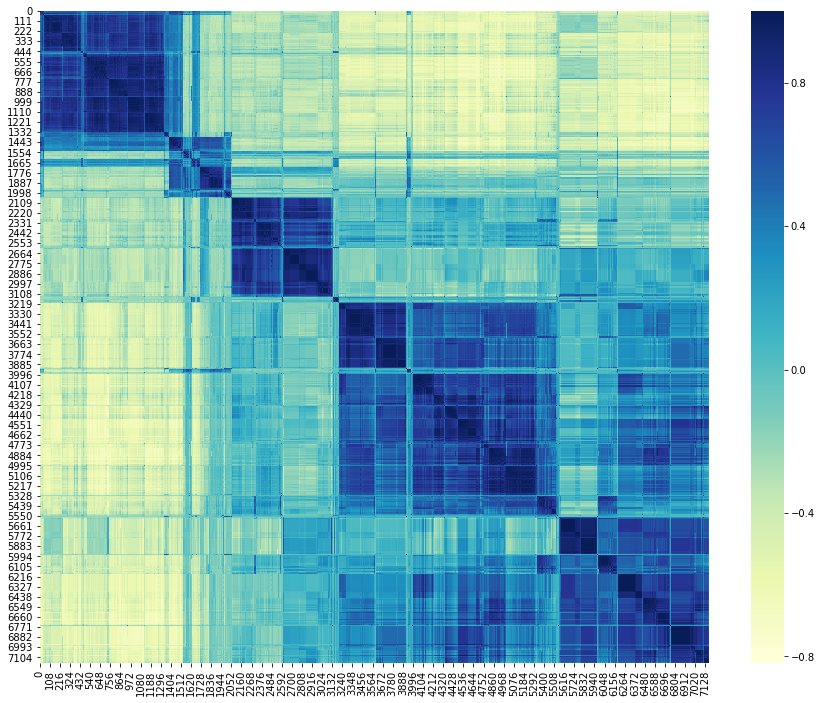

In [63]:
# cos_sim = decimate(cos_sim, 2)
plt.figure(figsize=(15,12))
sns.heatmap(cos_sim, cmap=cmap,)# norm=PowerNorm(gamma=15))

In [64]:
euc = np.abs(euc - euc.max())

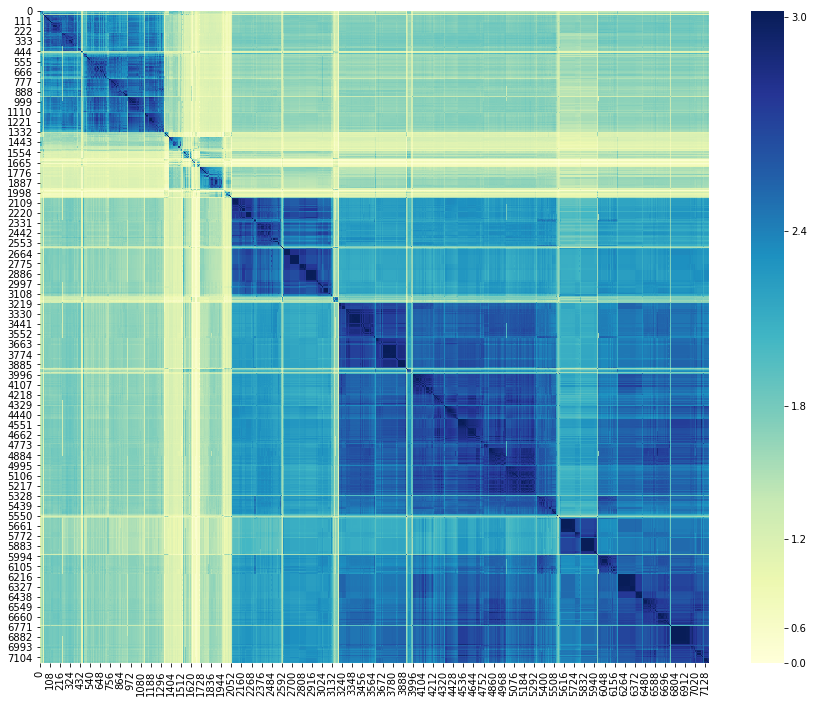

In [65]:
# euc = decimate(euc, 2)
plt.figure(figsize=(15,12))
sns.heatmap(euc, cmap=cmap, norm=PowerNorm(gamma=1.8))

In [112]:
test.shape

(58251, 4)

In [89]:
result_start.addr = [a.lower() for a in result_start.addr]

In [90]:
a = result_start.set_index('addr')

In [91]:
labels['addr'] = labels['address']

In [115]:
labels.drop_duplicates(subset='address', inplace=True)

In [120]:
labels.head()

,address,label,category,addr
0,0xadf8b8050639b6236915f7516d69de714672f0bf,Scanetchain,ar,0xadf8b8050639b6236915f7516d69de714672f0bf
1,0x6531f133e6deebe7f2dce5a0441aa7ef330b4e53,TIME,hr,0x6531f133e6deebe7f2dce5a0441aa7ef330b4e53
2,0xf8e386eda857484f5a12e4b5daa9984e06e73705,Indorse,hr,0xf8e386eda857484f5a12e4b5daa9984e06e73705
3,0xd2946be786f35c3cc402c29b323647abda799071,Vikky Token,hr,0xd2946be786f35c3cc402c29b323647abda799071
4,0x66d544b100966f99a72734c7eb471fb9556badfd,Time Money,hr,0x66d544b100966f99a72734c7eb471fb9556badfd


In [116]:
b = labels.set_index('addr')

In [117]:
test = a.join(b, how='left')

In [127]:
test['label'].isnull().values

array([ True,  True,  True, ...,  True,  True,  True])

In [140]:
#for each cluster
for c in range(cl.n_clusters):
    mask = cl.labels_ == c
    mask2 = test['label'].isnull().values
    current = test[['category', 'label']][mask&~mask2]
    size = np.sum(mask)
    print('cluster size: ' , size)
    print(current.groupby('category')['label'].count().sort_values(ascending=False)[:10])
    

cluster size:  8532
category
token-contract    53
gaming             7
token-sale         6
platform           5
phish-hack         5
payment            4
social             4
others             4
trading            3
dex                3
Name: label, dtype: int64
cluster size:  10859
category
token-contract    60
others             8
platform           6
exchange           6
trading            6
old-contract       5
gaming             4
token-sale         4
blockchain         4
mining             4
Name: label, dtype: int64
cluster size:  3289
category
token-contract    23
gaming             3
others             3
social             3
old-contract       3
donate             2
dex                2
mining             2
payment            2
agriculture        2
Name: label, dtype: int64
cluster size:  3283
category
token-contract    20
phish-hack         3
gaming             3
token-sale         2
exchange           2
real-estate        2
finance            2
old-contract       2
gamblin

In [71]:
pca_sub.shape

(57354, 29)

In [73]:
labels.shape

(7030, 3)